In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import PROJECT.util as f

In [4]:
def main_gradient_2_sans_proj_normalisation(iteration, u_p, v_p, Y, u_, v_, N, M, lambda_, beta_u, beta_v, lambda_1, lambda_2, dt):

    res = []
    
    mod = iteration*0.1

    for i in range(iteration):

        # Computation
        sqrt_dt = torch.sqrt(dt)

        u_1 = (1/lambda_1) * f.gradient_u_2(N, M, u_p,v_p,Y,lambda_) * dt
        u_2 = torch.sqrt(2/(lambda_1*beta_u)) * torch.empty(N).normal_(mean=0,std=sqrt_dt)
        u_3 = ((N-1)/(N*lambda_1*beta_u))*u_p*dt
        u_n = u_p - u_1 + u_2 - u_3

        v_1 = 1/lambda_2 * f.gradient_v_2(N,M,u_p,v_p,Y,lambda_) * dt
        v_2 = torch.sqrt(2/(lambda_2*beta_v)) * torch.empty(M).normal_(mean=0,std=sqrt_dt)
        v_3 = ((M-1)/(M*lambda_2*beta_v))*v_p*dt
        v_n = v_p - v_1 + v_2 - v_3

        # Normalisation
        u_n = u_n / torch.linalg.norm(u_n)
        v_n = v_n / torch.linalg.norm(v_n)
        u_n = u_n * torch.sqrt(N)
        v_n = v_n * torch.sqrt(M)

        # Re-asign for the loop
        u_p = u_n
        v_p = v_n
    
        res_u = torch.abs(f.overlap(u_,u_n,N))
        res_v = torch.abs(f.overlap(v_,v_n,M))
        res.append((res_u,res_v))
        
        if i%mod==0:
            print(f"progress {100*i/iteration:.2f}%", end="\r")
        if i==iteration-1:
            print(f"overlap(u, v): ({res_u}; {res_v})")

    return np.array(res)

In [14]:
def one_run(lambda_=2, N=5000, M=5000, beta_u=float("inf"), beta_v=float("inf"), lambda_1=1,
        lambda_2=1, dt=1/100, iteration=5000):
      #Size of the matrix Y
    N = torch.tensor(N)
    M = torch.tensor(M)

    # lambda
    lambda_ = torch.tensor(lambda_)

    #temperatures
    beta_u = torch.tensor(beta_u)
    beta_v = torch.tensor(beta_v)

    #learning rates
    lambda_1 = torch.tensor(lambda_1)
    lambda_2 = torch.tensor(lambda_2)

    # Pas de temps
    dt = torch.tensor(dt)

    u_ = f.generate_vector(N)
    v_ = f.generate_vector(M)

    Y = f.generate_Y(N, M, u_,v_, lambda_)
    #print(Y)

    # Conditions initiales
    u_p = f.generate_vector(N)
    v_p = f.generate_vector(M)

    # Perform the gradient descent
    res = main_gradient_2_sans_proj_normalisation(iteration, u_p, v_p, Y, u_, v_, N, M, lambda_, beta_u, beta_v, lambda_1, lambda_2, dt)
    
    return res


In [15]:
# MAIN METHOD:

def main(size_of_one_sample, list_value_):
    
    sample_iterations=[]
    sample_overlap_mean=[]
    
    for value_to_test in list_value_:
        
        # Calculation
        iterations_for_each_run = [one_run(lambda_=value_to_test) for _ in range(size_of_one_sample)]
        
        # Calculate mean 
        overlap_mean = np.array([x[-1] for x in iterations_for_each_run])
        
        # Store results
        sample_iterations.append(iterations_for_each_run)
        sample_overlap_mean.append(overlap_mean)
    return np.array(sample_iterations), np.array(sample_overlap_mean)

In [ ]:
# MAIN CELL: DO THE COMPUTATION

list_value_ = np.arange(0.1, 3, 0.1)
#list_value_ = np.array([0.2,0.5,0.7,1,1.3,1.8])

size_of_one_sample=10

(sample_iterations, sample_overlap_mean) = main(size_of_one_sample, list_value_)

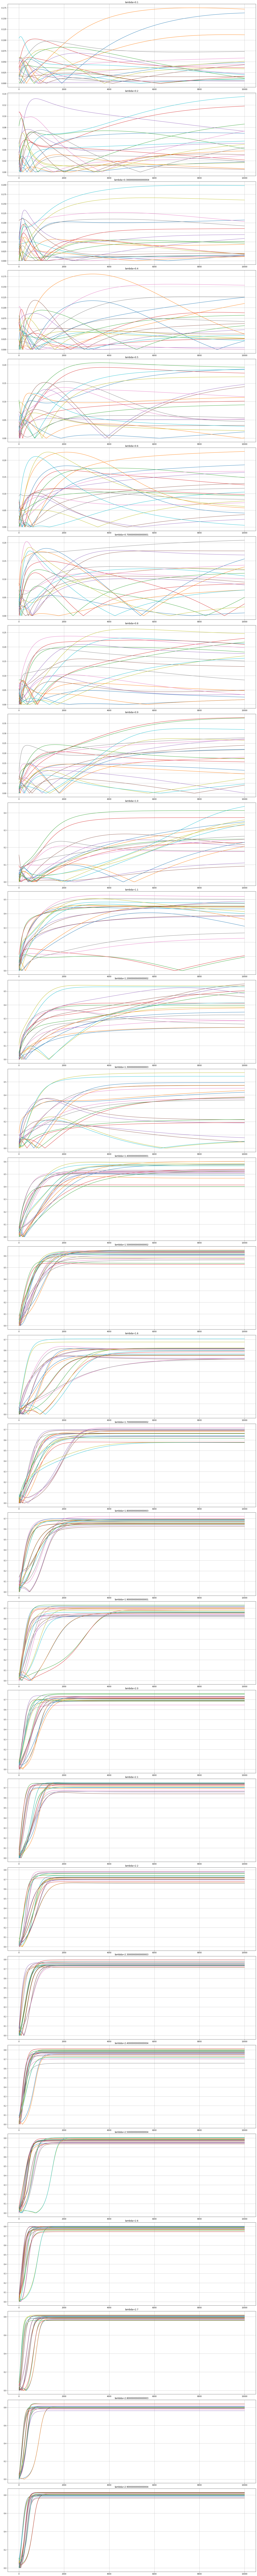

In [10]:
# PRINT THE OVERLAP IN FUNCTION OF THE STEP
fig, axs = plt.subplots(len(list_value_), figsize=(20,200))
fig.tight_layout()
for i in range(len(list_value_)):
    axs[i].grid()
    axs[i].set_title(f"lambda={list_value_[i]}")
    for run_in_on_sample in range(size_of_one_sample):
        axs[i].plot(sample_iterations[i][run_in_on_sample])

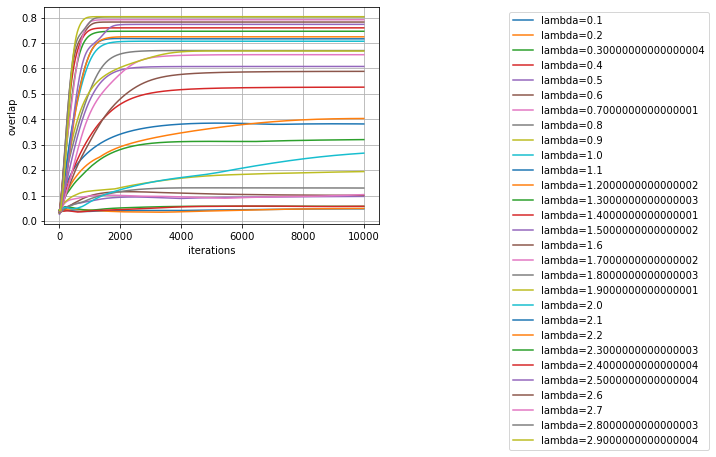

In [11]:
# PRINT THE OVERLAP IN FUNCTION OF THE STEP
iteration_mean_u_v=sample_iterations.mean(axis=1).mean(axis=2)
overlap_mean_u_v = sample_overlap_mean.mean(axis=1).mean(axis=1)

plt.figure(facecolor='white')
plt.grid()
plt.ylabel("overlap")
plt.xlabel("iterations")

for i in range(len(list_value_)):
    plt.plot(iteration_mean_u_v[i], label=f"lambda={list_value_[i]}")
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))

<ipython-input-12-f02527db9cea>:10: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(list_value_, (1-(1/list_value_))**0.5, linestyle="solid",


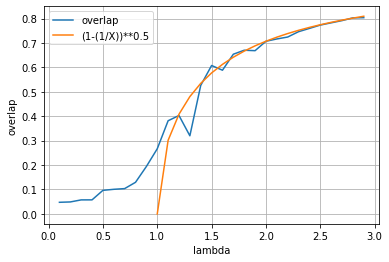

In [12]:
# BLUE LINE = OVERLAP
# ORANGE LINE = (1-(1/X))**0.5

plt.figure(facecolor='white')
plt.grid()
plt.ylabel("overlap")
plt.xlabel("lambda")
plt.plot(list_value_, overlap_mean_u_v, marker="", 
         linestyle ="solid", label="overlap")
plt.plot(list_value_, (1-(1/list_value_))**0.5, linestyle="solid",
         marker="", label="(1-(1/X))**0.5")
plt.legend()

In [ ]:
print(f"lambda= {list_value_[i]} -> {(1-(1/list_value_[i]))**0.5}, overlap: {overlap_mean_u_v[i]}")

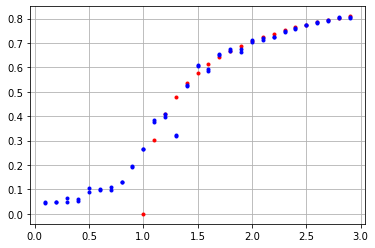

In [13]:
#Print overlap of u and v separatly:
plt.figure(facecolor='white')
plt.grid()
for i in range(len(list_value_)):
    if(list_value_[i]>=1):
        plt.plot(list_value_[i], (1-(1/list_value_[i]))**0.5, color="r", linestyle="solid", marker=".")
        
    # overlap u:
    plt.plot(list_value_[i], sample_overlap_mean.mean(axis=1)[i][0], color="b",
                marker=".", linestyle ="none")
    #overlap v:
    plt.plot(list_value_[i], sample_overlap_mean.mean(axis=1)[i][1], color="b",
                marker=".", linestyle = 'none')